# Azure OpenAI benchmarks report

Serge Retkowsky | 08-Jul-2024

<img src="img/logobench.jpg" width=600>

In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pytz
import requests
import seaborn as sns
import shutil
import sys

from datetime import datetime
from docx import Document
from docx.shared import Inches
from dotenv import load_dotenv
from IPython.display import display, FileLink

In [2]:
print(f"Python version: {sys.version}")

Python version: 3.10.11 (main, May 16 2023, 00:28:57) [GCC 11.2.0]


In [3]:
local_timezone = requests.get("https://ipinfo.io").json()["timezone"]
local_tz = pytz.timezone(local_timezone)
print(f"Local time in {local_timezone}: {datetime.now(local_tz).strftime('%d-%b-%Y %H:%M:%S')}")

Local time in Europe/Amsterdam: 11-Jul-2024 15:30:44


In [4]:
dt = datetime.now(local_tz).strftime('%d%b%Y_%H%M%S')

## 1. Settings

In [5]:
%%javascript Python 
OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [6]:
RESULTS_DIR = "results"

In [7]:
REPORT_DIR = "report4"

os.makedirs(REPORT_DIR, exist_ok=True)

In [8]:
def get_list_benchmark_files(results_directory):
    """
    Get a python list from the excel benchmarks files
    """
    benchmark_files = []

    for root, dirs, files in os.walk(results_directory):
        for file in files:
            if "and" in file and file.endswith(('.xlsx')):
                full_path = os.path.join(root, file)
                benchmark_files.append(full_path)

    return benchmark_files

In [9]:
def apply_gradient(dataframe, cmap):
    styled = dataframe.style
    for col in dataframe.columns:
        if col != 'count':
            styled = styled.background_gradient(
                cmap=cmap,
                subset=pd.IndexSlice[dataframe.index.difference(['count']),
                                     col])
    return styled

In [10]:
def add_images_to_word(directory, output_file):
    """
    Adding all images from a dir to a word files
    """
    doc = Document()
    
    for filename in os.listdir(directory):
        if filename.lower().endswith('.png'):
            doc.add_heading(filename, level=1)
            image_path = os.path.join(directory, filename)
            doc.add_picture(image_path, width=Inches(6.0))
            doc.add_page_break()
    
    doc.save(output_file)
    print(f'Done. Document saved as {output_file}')

In [11]:
metrics_labels = {
    "time": "Time offset in seconds since the start of the test",
    "rpm": "Successful Requests Per Minute",
    "tpm": "Tokens Per Minute",
    "processing": "Total number of requests currently being processed by the endpoint",
    "completed": "Total number of completed requests",
    "failures": "Total number of failed requests out of requests",
    "throttled": "Total number of throttled requests out of requests",
    "requests": "Deprecated in favor of completed field (output values of both fields are the same)",
    "ttft_avg": "Average time in seconds from the beginning of the request until the first token was received",
    "ttft_95th": "95th percentile of time in seconds from the beginning of the request until the first token was received",
    "tbt_avg": "Average time in seconds between two consecutive generated tokens",
    "tbt_95th": "95th percentile of time in seconds between two consecutive generated tokens",
    "e2e_avg": "Average end to end request time",
    "e2e_95th": "95th percentile of end to end request time",
    "util_avg": "Average deployment utilization percentage as reported by the service",
    "util_95th": "95th percentile of deployment utilization percentage as reported by the service"
}

print("Benchmark labels:\n")
for idx in metrics_labels:
    print(f"- {metrics_labels[idx]}")

Benchmark labels:

- Time offset in seconds since the start of the test
- Successful Requests Per Minute
- Tokens Per Minute
- Total number of requests currently being processed by the endpoint
- Total number of completed requests
- Total number of failed requests out of requests
- Total number of throttled requests out of requests
- Deprecated in favor of completed field (output values of both fields are the same)
- Average time in seconds from the beginning of the request until the first token was received
- 95th percentile of time in seconds from the beginning of the request until the first token was received
- Average time in seconds between two consecutive generated tokens
- 95th percentile of time in seconds between two consecutive generated tokens
- Average end to end request time
- 95th percentile of end to end request time
- Average deployment utilization percentage as reported by the service
- 95th percentile of deployment utilization percentage as reported by the service


In [12]:
load_dotenv("azure.env")

# For model 1
MODEL1 = os.getenv("MODEL1")
MODEL1_LABEL = os.getenv("MODEL1_LABEL")
COLOR1 = os.getenv("COLOR1")

# For model2
MODEL2 = os.getenv("MODEL2")
MODEL2_LABEL = os.getenv("MODEL2_LABEL")
COLOR2 = os.getenv("COLOR2")

## 2. All results

In [18]:
benchmark_files = get_list_benchmark_files(RESULTS_DIR)
benchmark_files.sort()
benchmark_files = benchmark_files[37:]
benchmark_files

['results/results_11Jul2024_145937/benchmarks_gpt-4o PAYGO Sweden_and_gpt-4o PTU Sweden_11Jul2024_145937.xlsx',
 'results/results_11Jul2024_150713/benchmarks_gpt-4o PAYGO Sweden_and_gpt-4o PTU Sweden_11Jul2024_150713.xlsx',
 'results/results_11Jul2024_151502/benchmarks_gpt-4o PAYGO Sweden_and_gpt-4o PTU Sweden_11Jul2024_151502.xlsx',
 'results/results_11Jul2024_152243/benchmarks_gpt-4o PAYGO Sweden_and_gpt-4o PTU Sweden_11Jul2024_152243.xlsx']

In [19]:
print(f"Number of benchmarks files to analyze = {len(benchmark_files)}\n")

for idx, file in enumerate(benchmark_files):
    print(f"Bench {idx+1} = {file}")

Number of benchmarks files to analyze = 4

Bench 1 = results/results_11Jul2024_145937/benchmarks_gpt-4o PAYGO Sweden_and_gpt-4o PTU Sweden_11Jul2024_145937.xlsx
Bench 2 = results/results_11Jul2024_150713/benchmarks_gpt-4o PAYGO Sweden_and_gpt-4o PTU Sweden_11Jul2024_150713.xlsx
Bench 3 = results/results_11Jul2024_151502/benchmarks_gpt-4o PAYGO Sweden_and_gpt-4o PTU Sweden_11Jul2024_151502.xlsx
Bench 4 = results/results_11Jul2024_152243/benchmarks_gpt-4o PAYGO Sweden_and_gpt-4o PTU Sweden_11Jul2024_152243.xlsx


In [20]:
dfs = []

for file in benchmark_files:
    df = pd.read_excel(file)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df = df.drop(['index', 'Unnamed: 0'], axis=1)
percentage_columns = ['util_avg', 'util_95th']

for col in percentage_columns:
    df[col] = df[col].str.replace('%', '').astype(float).fillna(0)

df = df[df['ttft_avg'] != 0]

In [21]:
df = df.set_index('timestamp')
df

,rpm,processing,completed,failures,throttled,requests,tpm,ttft_avg,ttft_95th,tbt_avg,tbt_95th,e2e_avg,e2e_95th,util_avg,util_95th,model
timestamp,,,,,,,,,,,,,,,,
2024-07-11 12:59:52,60.0,20,3,0,0,3,24240,0.228,0.244,0.011,0.013,2.557,2.901,0.0,0.0,gpt-4o
2024-07-11 12:59:53,120.0,20,8,0,0,8,48480,0.254,0.332,0.014,0.018,3.111,3.855,0.0,0.0,gpt-4o
2024-07-11 12:59:54,120.0,20,10,0,0,10,48480,0.239,0.321,0.014,0.018,3.108,3.946,0.0,0.0,gpt-4o
2024-07-11 12:59:55,220.0,20,22,0,0,22,88880,0.255,0.342,0.019,0.024,4.068,5.131,0.0,0.0,gpt-4o
2024-07-11 12:59:56,205.7,20,24,0,0,24,83109,0.246,0.341,0.019,0.024,4.054,5.131,0.0,0.0,gpt-4o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-11 13:29:22,148.0,7,639,0,0,639,59644,5.408,19.514,0.015,0.021,5.948,16.990,99.7,100.0,gpt-4o-2024-05-13-ptu
2024-07-11 13:29:23,151.0,4,642,0,0,642,60853,5.448,19.359,0.015,0.021,5.971,17.154,99.7,100.0,gpt-4o-2024-05-13-ptu
2024-07-11 13:29:24,147.0,3,643,0,0,643,59241,5.332,18.212,0.015,0.021,5.985,17.144,99.7,100.0,gpt-4o-2024-05-13-ptu


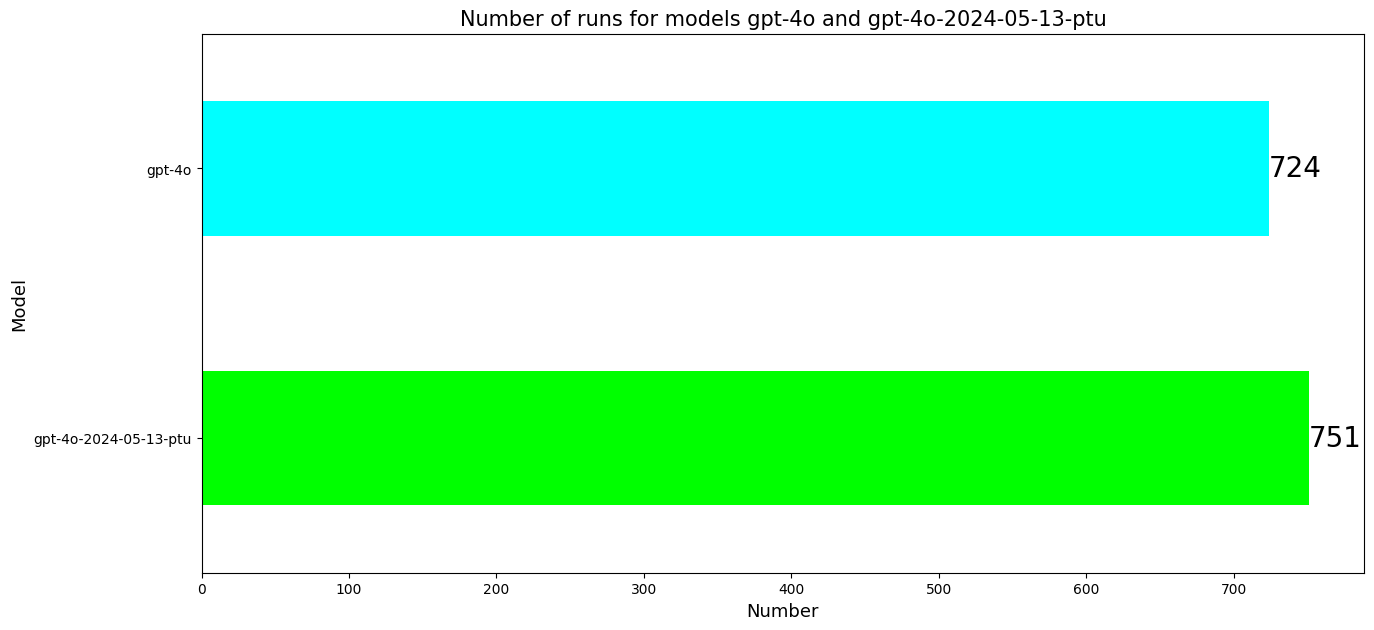

In [22]:
colors = [COLOR1, COLOR2]
plt.figure(figsize=(15, 7))

value_counts = df['model'].value_counts(sort=True)
ax = value_counts.plot.barh(color=colors)
plt.xlabel('Number', size=13)
plt.ylabel('Model', size=13)
plt.title(f"Number of runs for models {MODEL1} and {MODEL2}", size=15)

for index, value in enumerate(value_counts):
    ax.text(value, index, str(value), va='center', ha='left', size=20)

plt.show()

## 3. Plots

In [23]:
int_columns = ['failures', 'throttled']

float_columns = [
    'rpm', 'tpm', 'ttft_avg', 'ttft_95th', 'tbt_avg', 'tbt_95th', 'e2e_avg',
    'e2e_95th', 'util_avg', 'util_95th'
]

cols_to_plot = int_columns + float_columns

values_to_min = [
    'failures', 'throttled', 'ttft_avg', 'ttft_95th', 'tbt_avg', 'tbt_95th',
    'e2e_avg', 'e2e_95th'
]
values_to_max = ['rpm', 'tpm']
values_misc = ['util_avg', 'util_95th']

In [24]:
cm = sns.light_palette('darkblue', as_cmap=True)

In [25]:
idx = 1
for col in values_to_max:
    statistics = df.groupby('model')[col].describe()
    print(f"\n{idx} Statistics for metric: {col.upper()} ({metrics_labels[col]})")
    styled_statistics = apply_gradient(statistics, cm)
    display(styled_statistics)
    print("\n", "-" * 90)
    idx += 1


1 Statistics for metric: RPM (Successful Requests Per Minute)


,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
gpt-4o,724.000000,307.522790,42.607293,60.000000,302.000000,313.000000,325.000000,387.800000
gpt-4o-2024-05-13-ptu,751.000000,213.257257,67.600192,20.000000,151.000000,199.000000,276.000000,340.500000



 ------------------------------------------------------------------------------------------

2 Statistics for metric: TPM (Tokens Per Minute)


,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
gpt-4o,724.000000,124008.078729,17173.381644,24180.000000,121706.000000,126139.000000,130975.000000,156285.000000
gpt-4o-2024-05-13-ptu,751.000000,86103.894807,27297.336778,8060.000000,60853.000000,80595.000000,111780.000000,137222.000000



 ------------------------------------------------------------------------------------------


In [26]:
idx = 1

for col in values_to_min:
    statistics = df.groupby('model')[col].describe()
    print(f"\n{idx} Statistics for {col.upper()} ({metrics_labels[col]})")
    styled_statistics = statistics.style.apply(
        lambda x:
        ['background-color: lightblue' if v == x.min() else '' for v in x],
        axis=0)
    display(styled_statistics)
    print("\n", "-" * 90)
    idx += 1


1 Statistics for FAILURES (Total number of failed requests out of requests)


,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
gpt-4o,724.000000,5589.136740,5478.647862,0.000000,0.000000,5548.500000,10624.000000,18061.000000
gpt-4o-2024-05-13-ptu,751.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000



 ------------------------------------------------------------------------------------------

2 Statistics for THROTTLED (Total number of throttled requests out of requests)


,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
gpt-4o,724.000000,5589.136740,5478.647862,0.000000,0.000000,5548.500000,10624.000000,18061.000000
gpt-4o-2024-05-13-ptu,751.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000



 ------------------------------------------------------------------------------------------

3 Statistics for TTFT_AVG (Average time in seconds from the beginning of the request until the first token was received)


,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
gpt-4o,724.000000,0.147757,0.024736,0.123000,0.132000,0.143000,0.152000,0.286000
gpt-4o-2024-05-13-ptu,751.000000,2.284840,1.989050,0.163000,0.207500,1.704000,4.424500,5.487000



 ------------------------------------------------------------------------------------------

4 Statistics for TTFT_95TH (95th percentile of time in seconds from the beginning of the request until the first token was received)


,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
gpt-4o,724.000000,0.220307,0.061872,0.149000,0.167000,0.191500,0.286000,0.369000
gpt-4o-2024-05-13-ptu,751.000000,8.653929,7.393351,0.000000,0.341000,9.401000,15.524000,23.323000



 ------------------------------------------------------------------------------------------

5 Statistics for TBT_AVG (Average time in seconds between two consecutive generated tokens)


,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
gpt-4o,724.000000,0.016981,0.001771,0.011000,0.016000,0.016000,0.018000,0.023000
gpt-4o-2024-05-13-ptu,751.000000,0.017755,0.002099,0.011000,0.017000,0.017000,0.019000,0.025000



 ------------------------------------------------------------------------------------------

6 Statistics for TBT_95TH (95th percentile of time in seconds between two consecutive generated tokens)


,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
gpt-4o,724.000000,0.024287,0.005170,0.012000,0.021000,0.023000,0.028000,0.036000
gpt-4o-2024-05-13-ptu,751.000000,0.027073,0.006079,0.000000,0.023000,0.026000,0.031000,0.039000



 ------------------------------------------------------------------------------------------

7 Statistics for E2E_AVG (Average end to end request time)


,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
gpt-4o,724.000000,3.594670,0.333967,2.534000,3.346750,3.546500,3.783750,4.976000
gpt-4o-2024-05-13-ptu,751.000000,4.783085,0.794928,2.419000,4.163500,4.859000,5.486500,6.066000



 ------------------------------------------------------------------------------------------

8 Statistics for E2E_95TH (95th percentile of end to end request time)


,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
gpt-4o,724.000000,5.541547,1.139024,2.749000,4.622500,5.594500,6.483000,7.517000
gpt-4o-2024-05-13-ptu,751.000000,10.237128,3.861681,0.000000,7.194500,10.235000,13.580000,17.154000



 ------------------------------------------------------------------------------------------


In [27]:
# Only available for PTU deployed models

idx = 1

for col in values_misc:
    statistics = df.groupby('model')[col].describe()
    print(f"\n{idx} Statistics for metric: {col.upper()} ({metrics_labels[col]})")
    display(statistics)
    print("\n", "-" * 90)
    idx += 1


1 Statistics for metric: UTIL_AVG (Average deployment utilization percentage as reported by the service)


,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
gpt-4o,724.0,0.000000,0.00000,0.0,0.00,0.0,0.0,0.0
gpt-4o-2024-05-13-ptu,751.0,70.643808,33.43007,4.9,40.55,88.6,99.7,99.8



 ------------------------------------------------------------------------------------------

2 Statistics for metric: UTIL_95TH (95th percentile of deployment utilization percentage as reported by the service)


,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
gpt-4o,724.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0
gpt-4o-2024-05-13-ptu,751.0,83.586951,28.519164,0.0,77.25,100.0,100.0,100.0



 ------------------------------------------------------------------------------------------


1


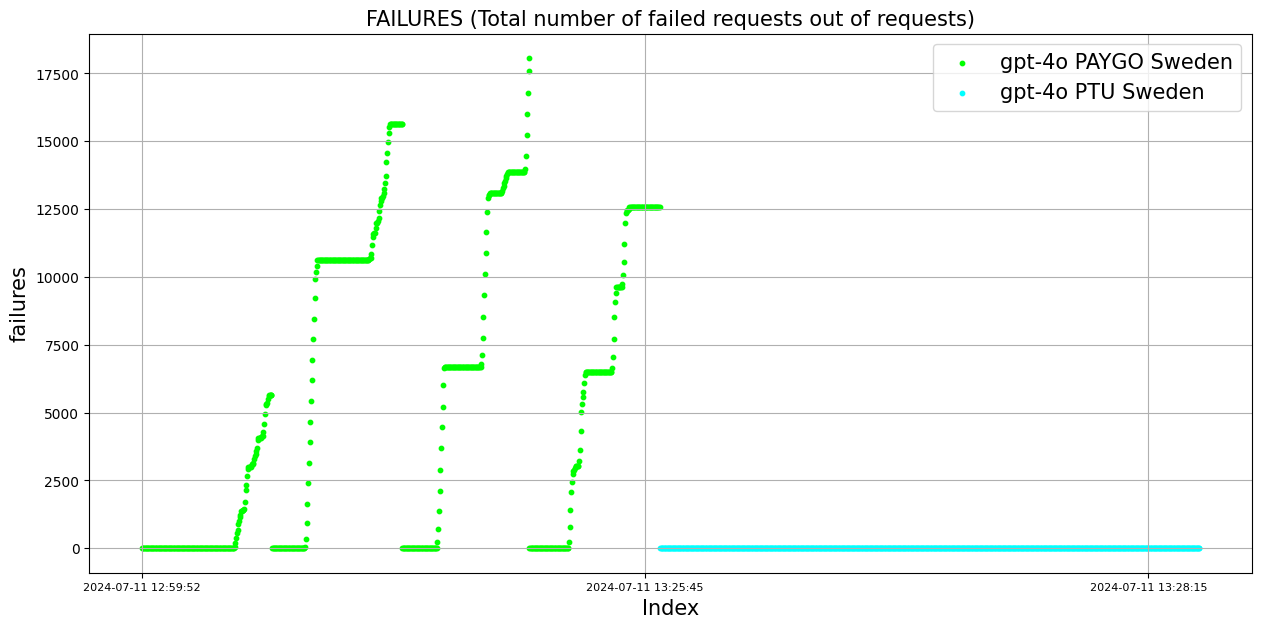

2


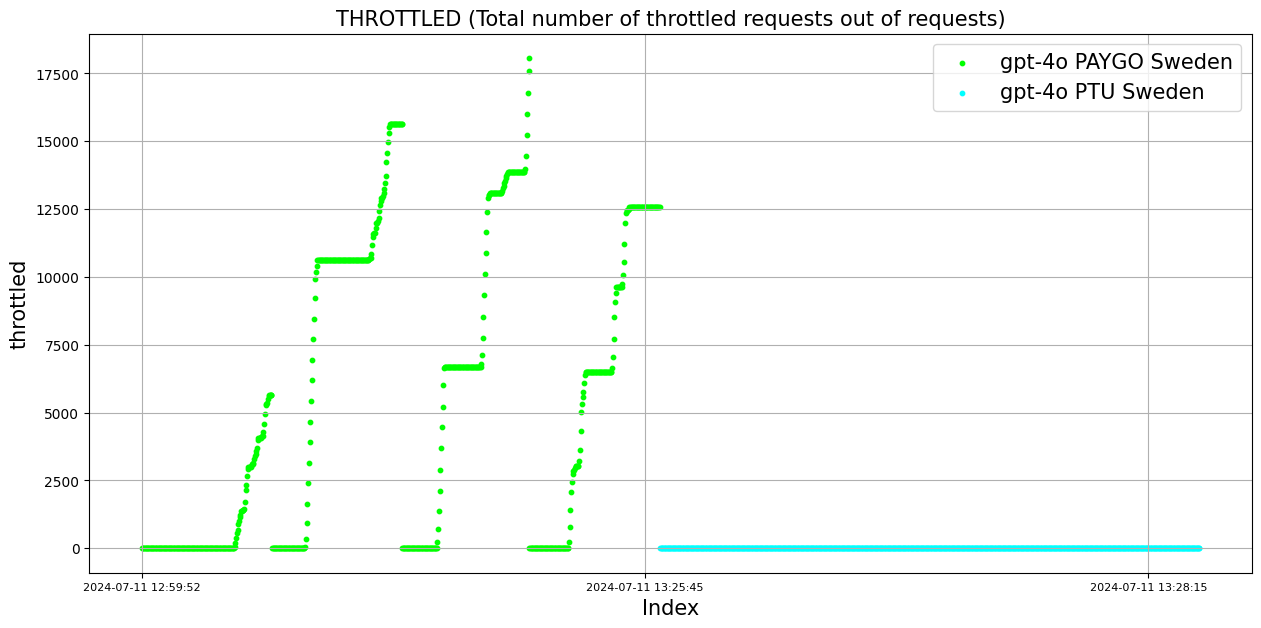

3


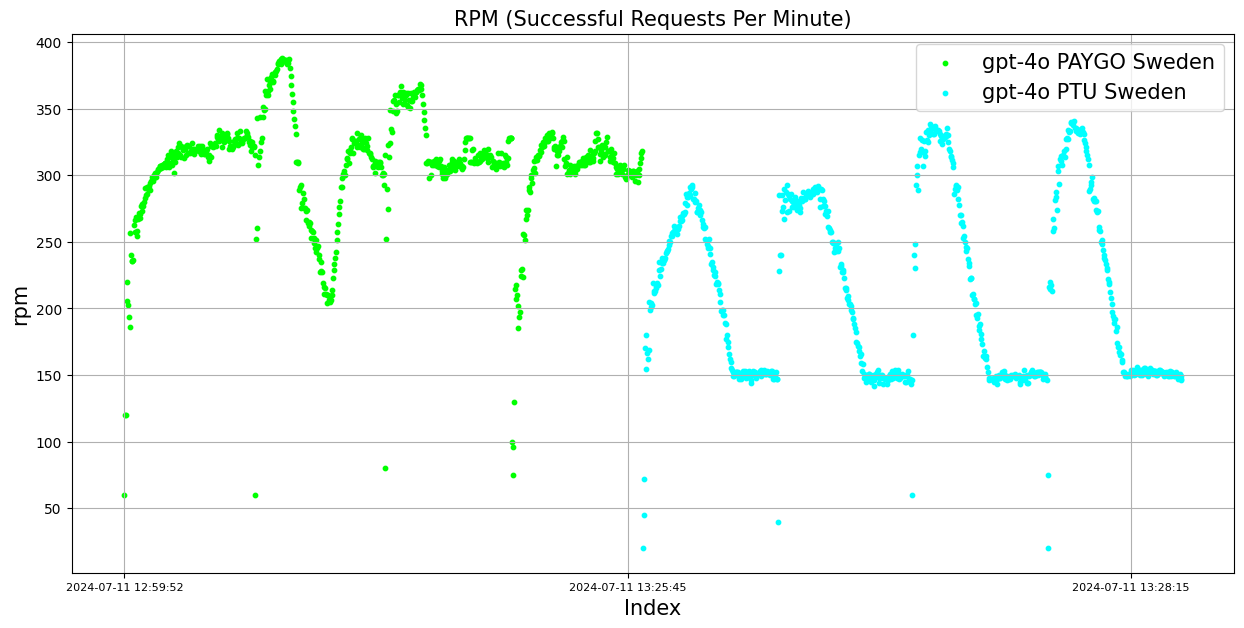

4


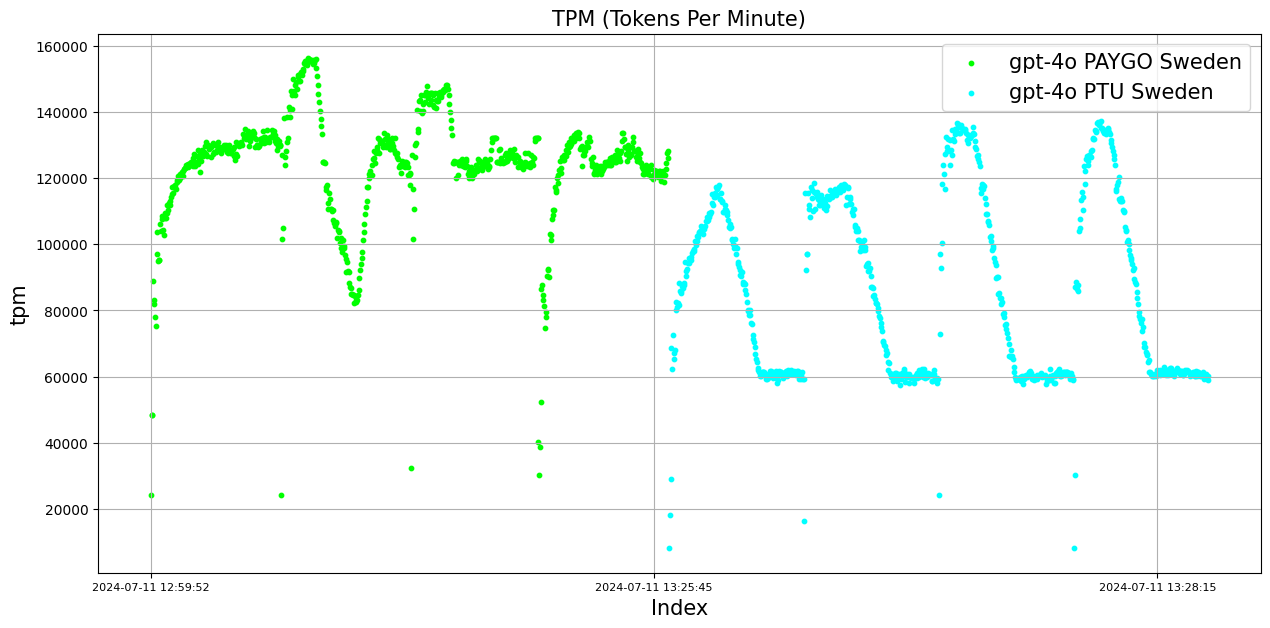

5


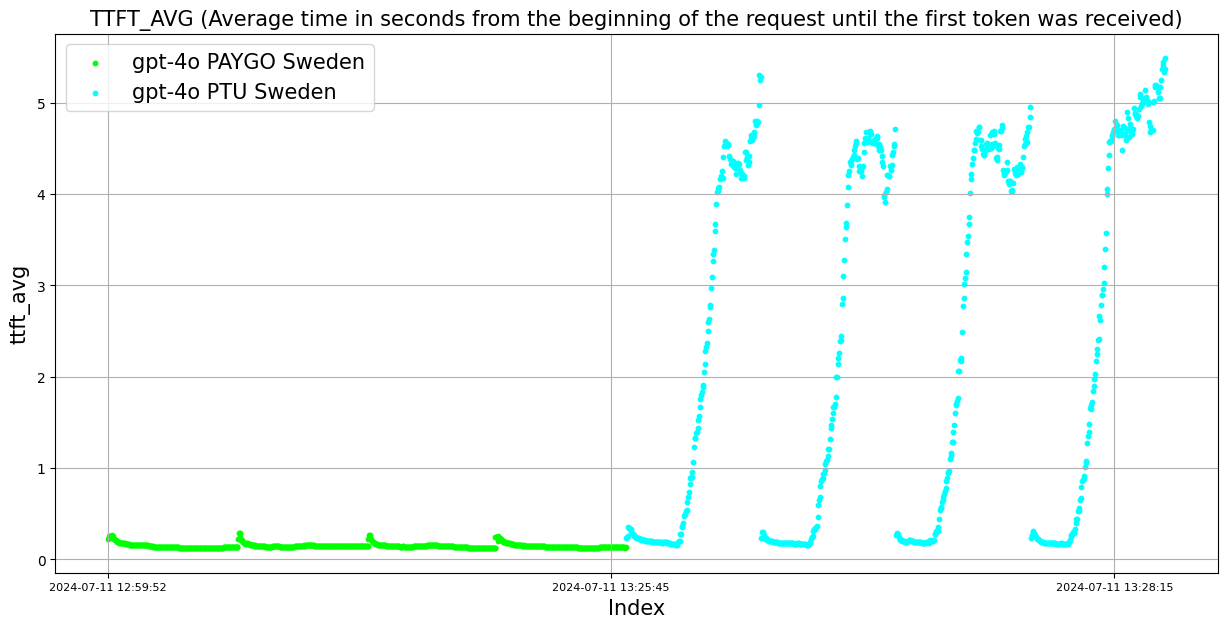

6


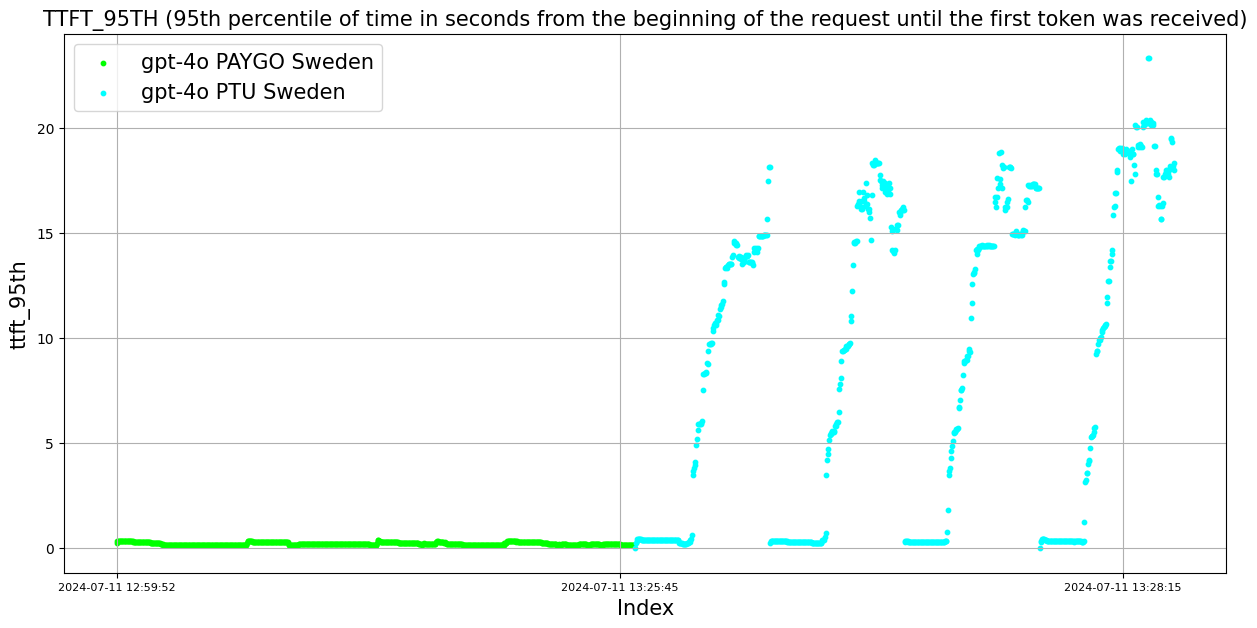

7


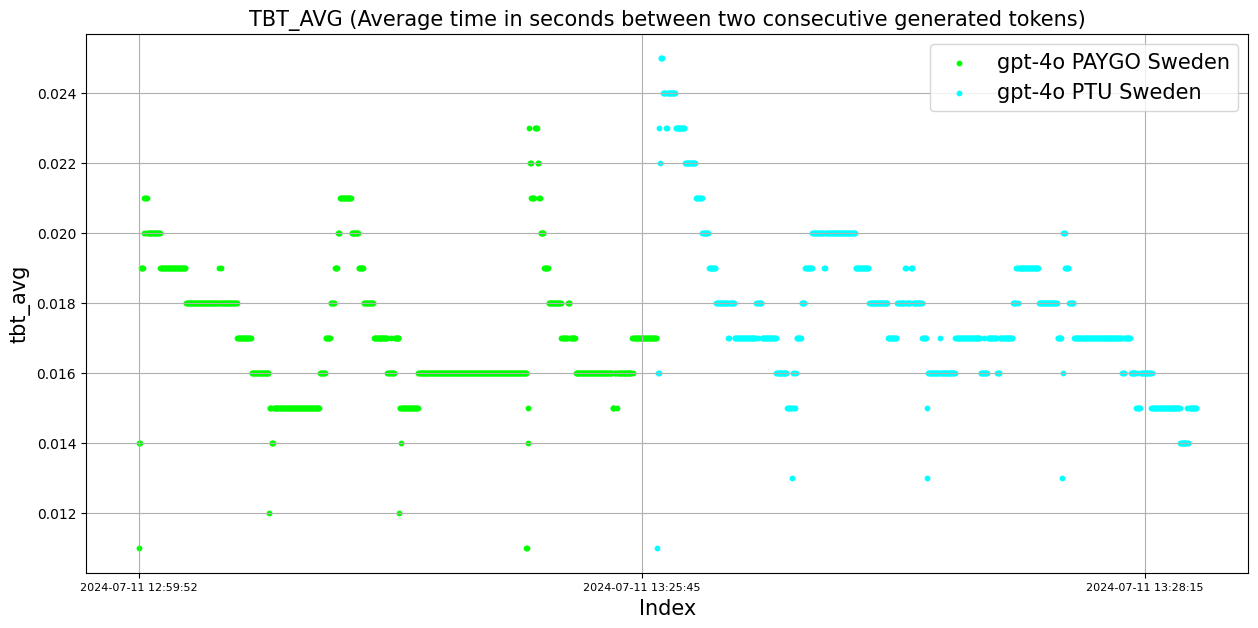

8


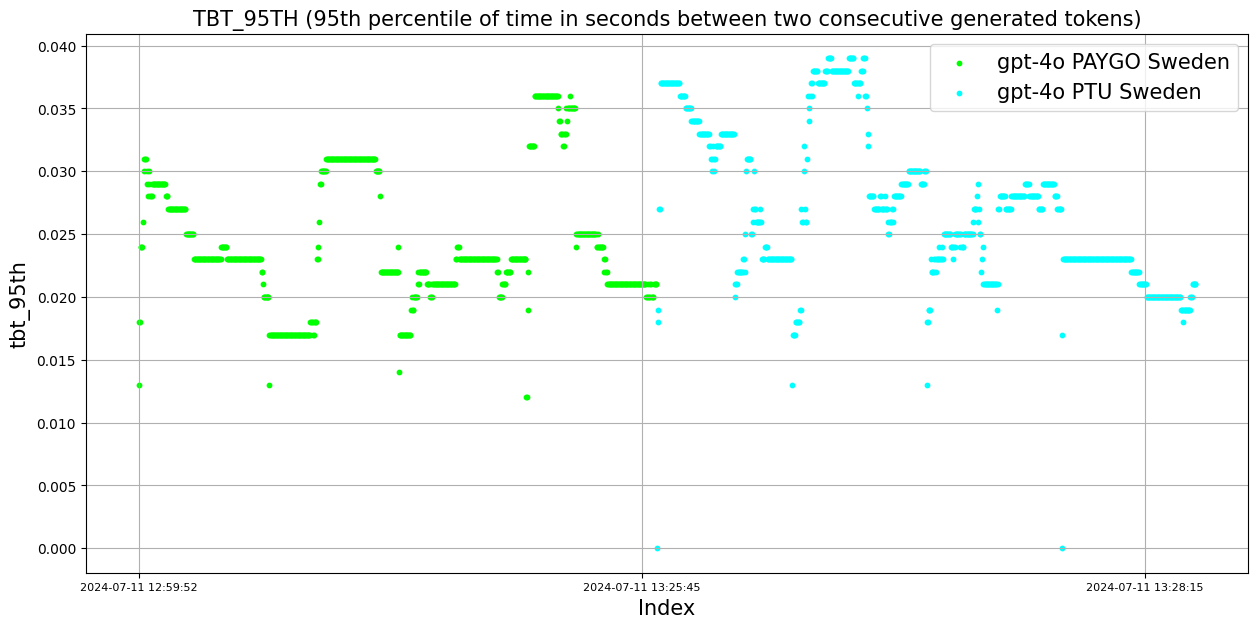

9


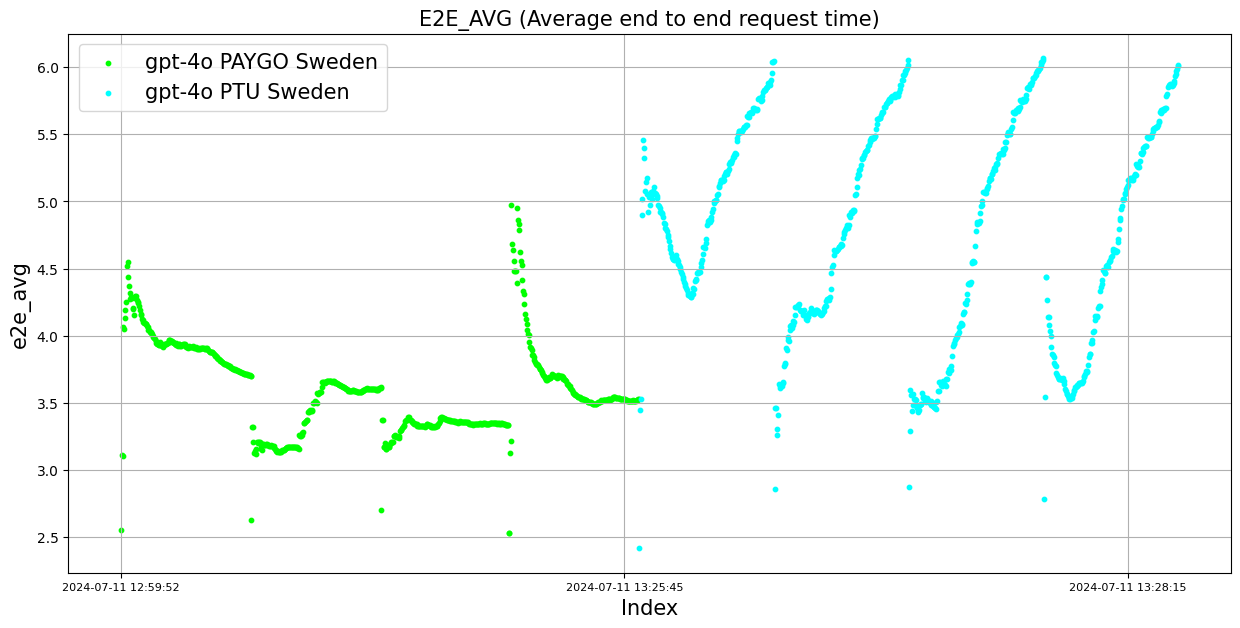

10


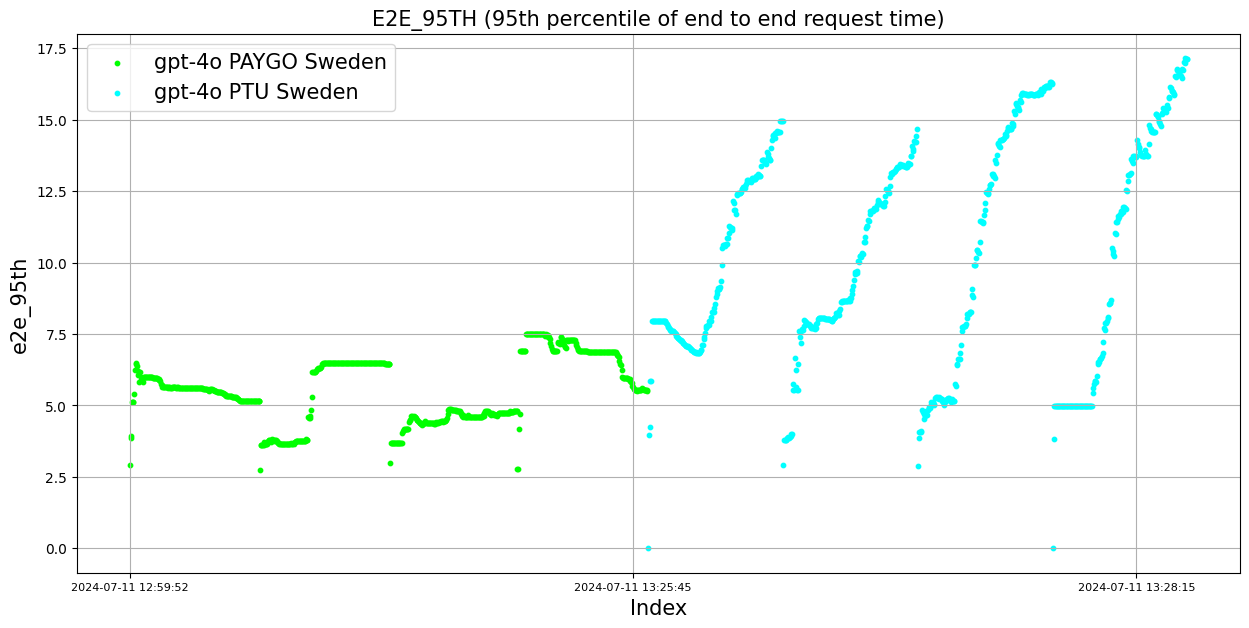

11


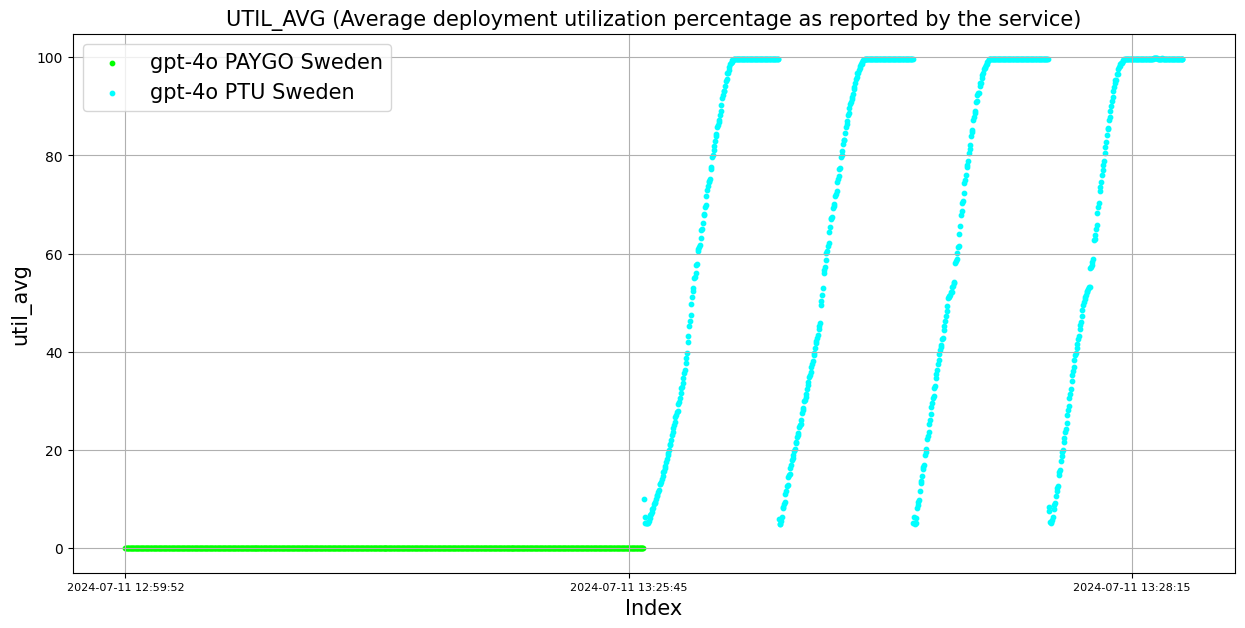

12


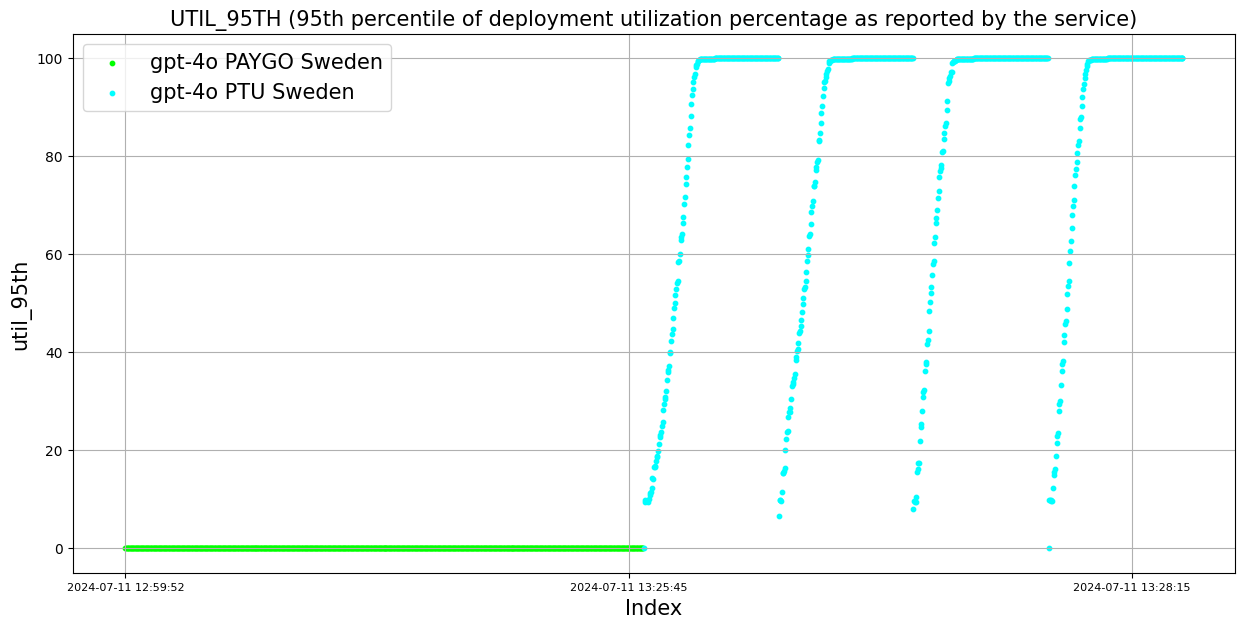

In [28]:
marker_size = 10
idx = 1
color_map = {MODEL1: COLOR1, MODEL2: COLOR2}
legend_labels = {
    MODEL1: MODEL1_LABEL,
    MODEL2: MODEL2_LABEL
}

for col in cols_to_plot:
    plt.figure(figsize=(15, 7))
    print(idx)
    
    for value in df['model'].unique():
        subset = df[df['model'] == value]
        plt.scatter(subset.index,
                    subset[col],
                    label=legend_labels[value],
                    color=color_map[value],
                    s=marker_size)
    
    plt.xticks(np.arange(0, len(df), step=700), size=8)
    plt.xlabel('Index', fontsize=15)
    plt.ylabel(col, fontsize=15)
    plt.title(f'{col.upper()} ({metrics_labels[col]})', fontsize=15)
    plt.legend(fontsize=15)
    plt.grid(True)
    output = os.path.join(REPORT_DIR, f'plot_{col}_{dt}.png')
    plt.savefig(output, format='jpg', dpi=300)
    plt.show()
    idx += 1

1


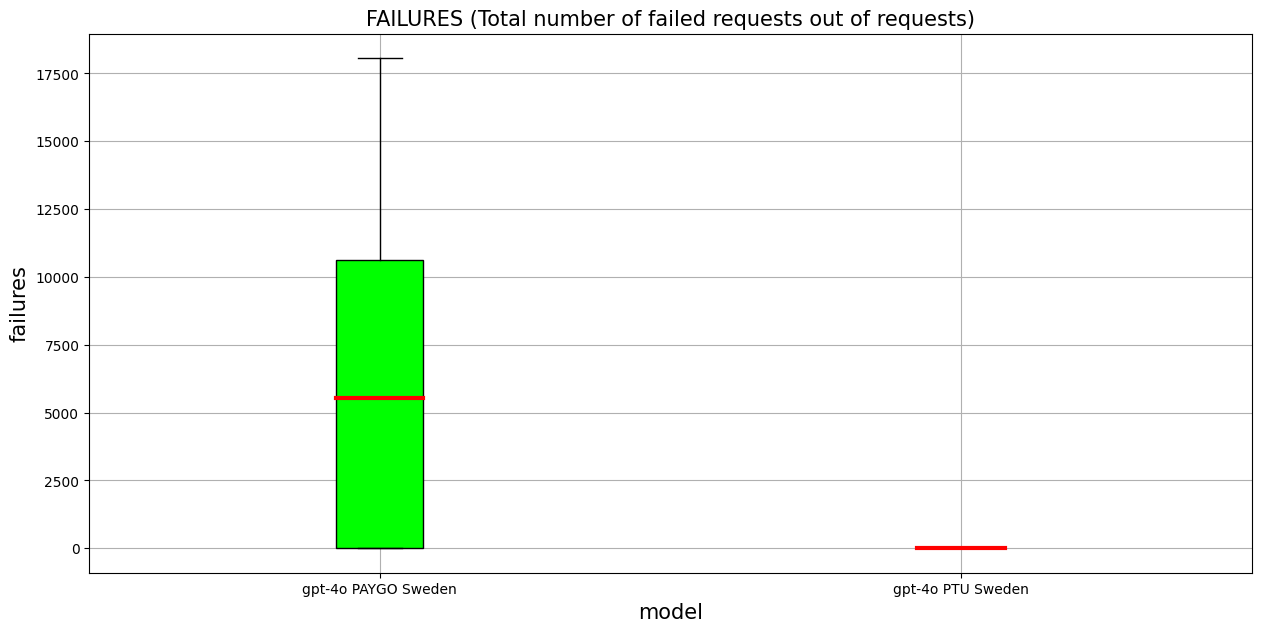

2


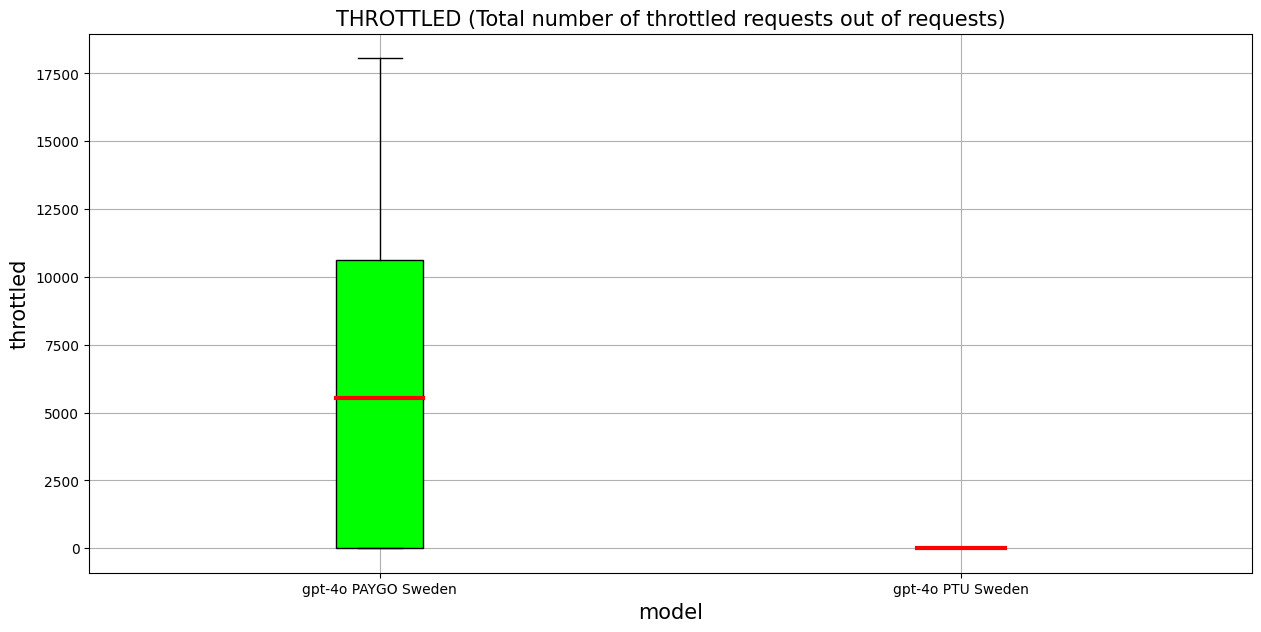

3


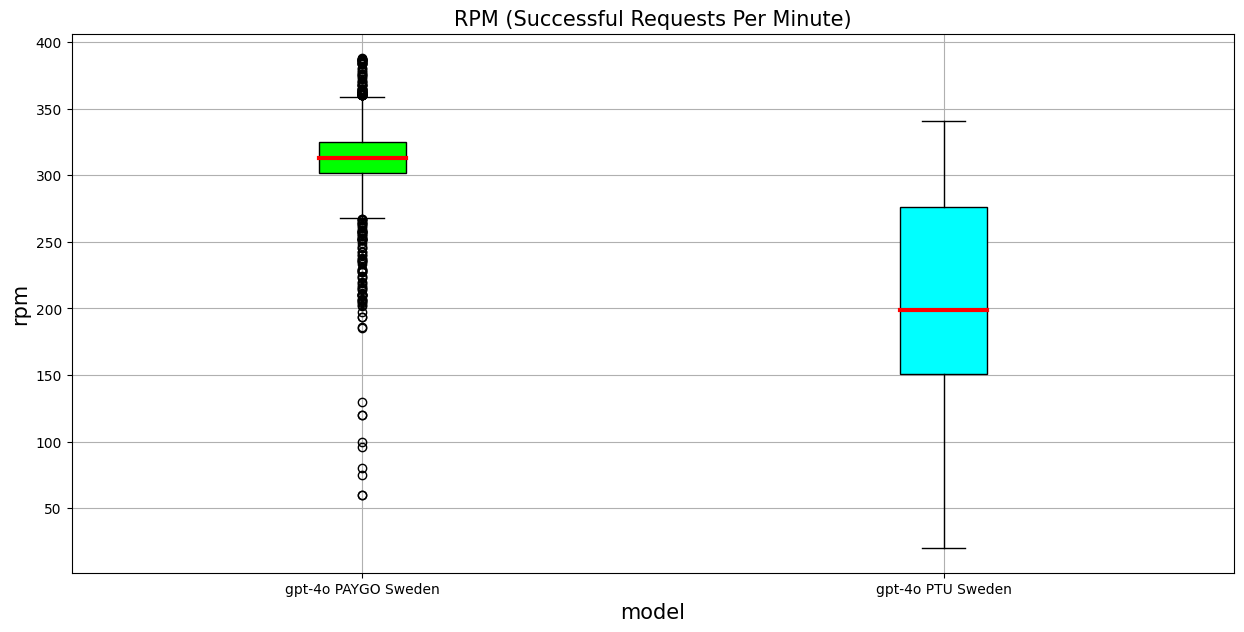

4


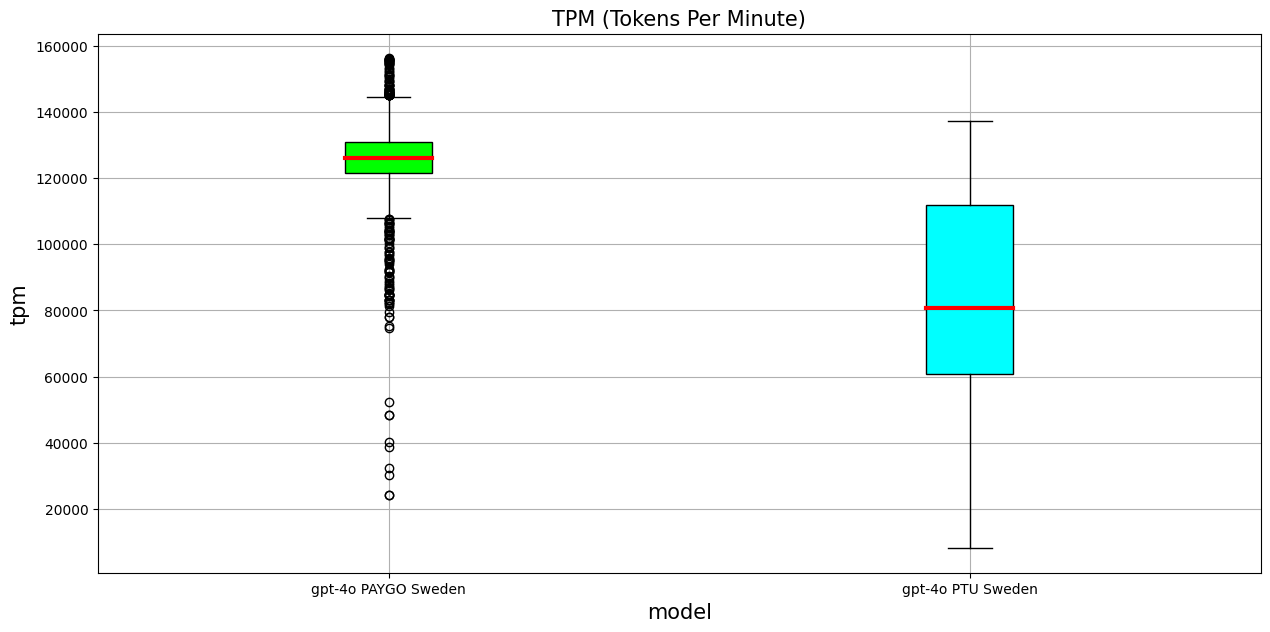

5


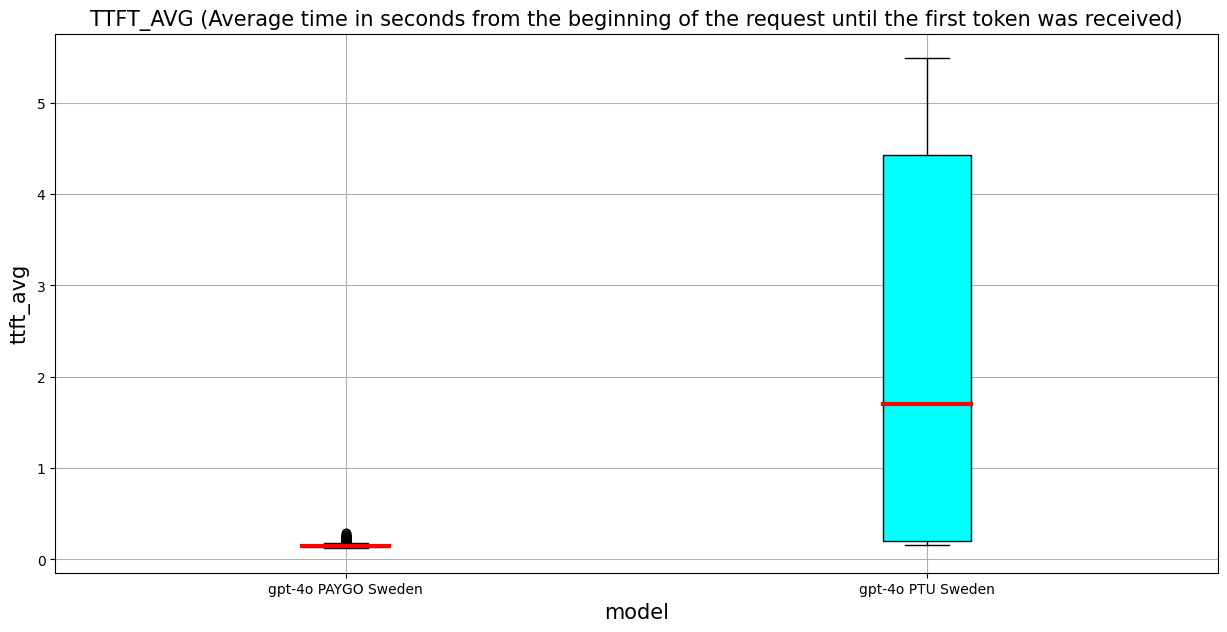

6


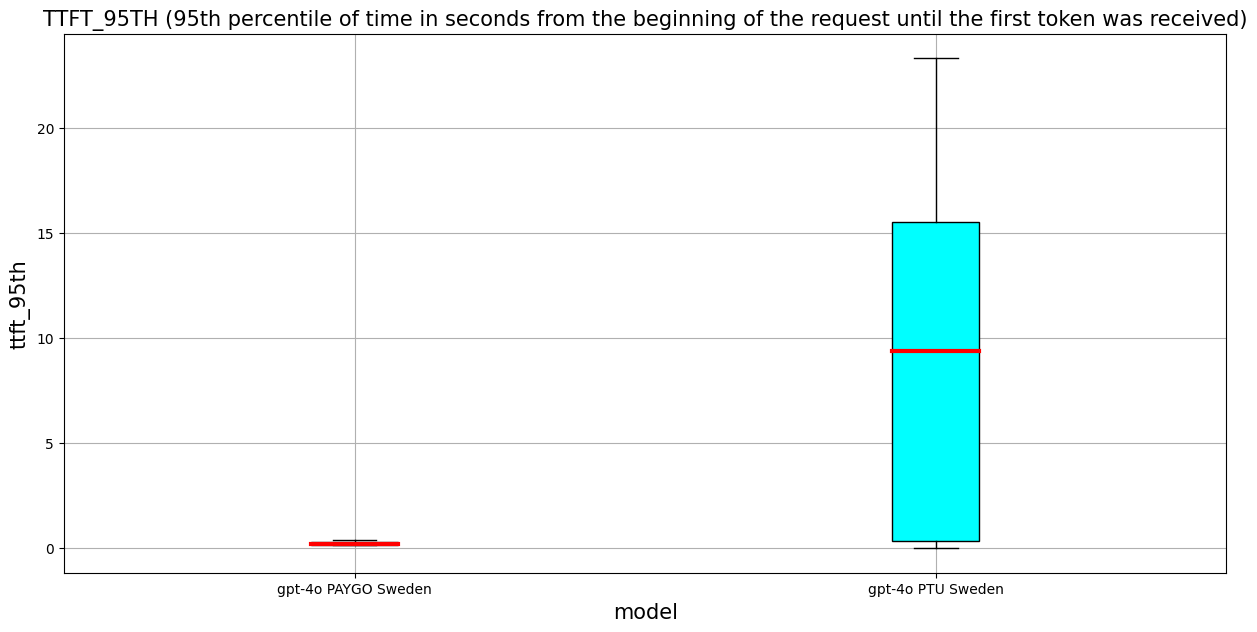

7


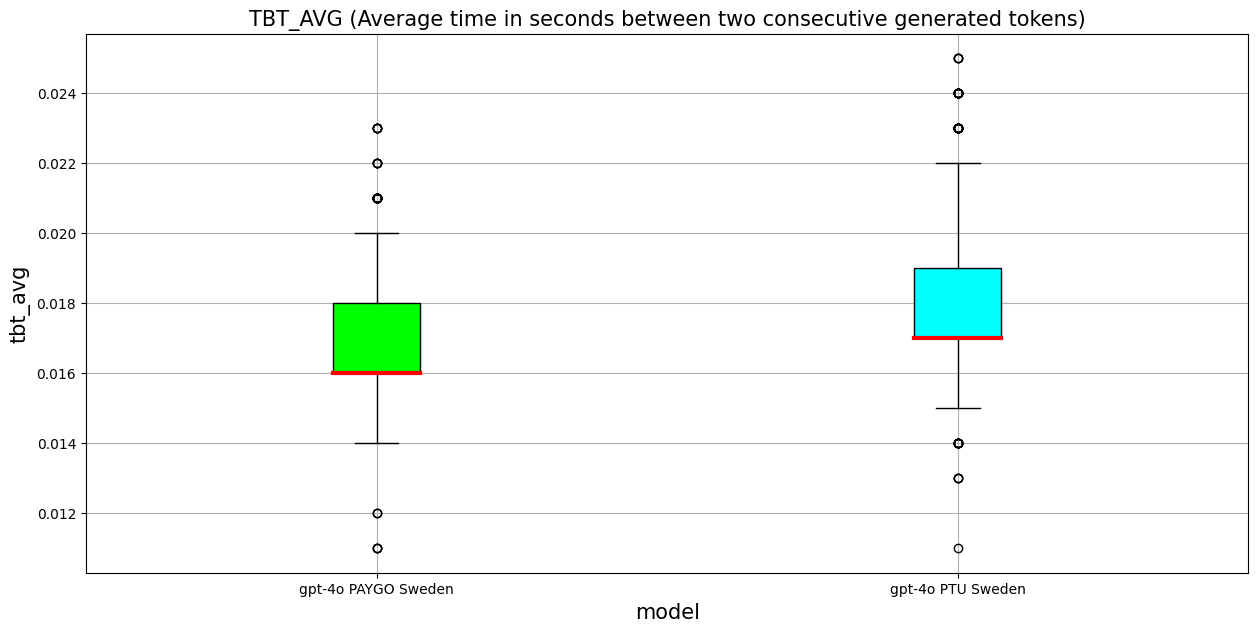

8


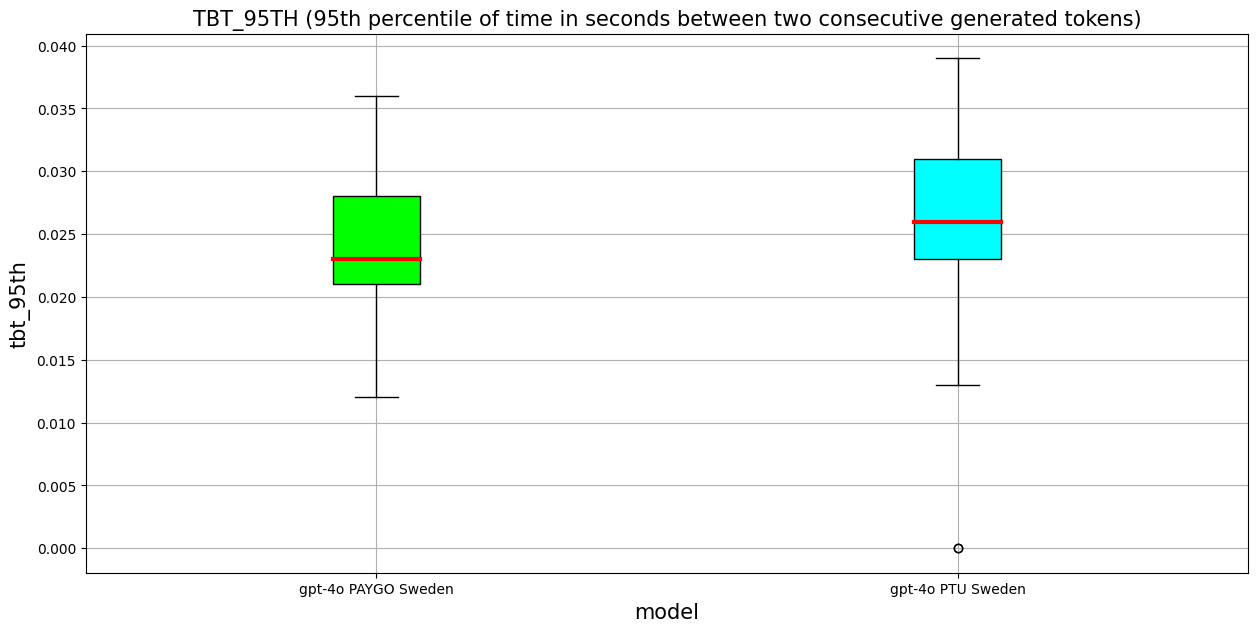

9


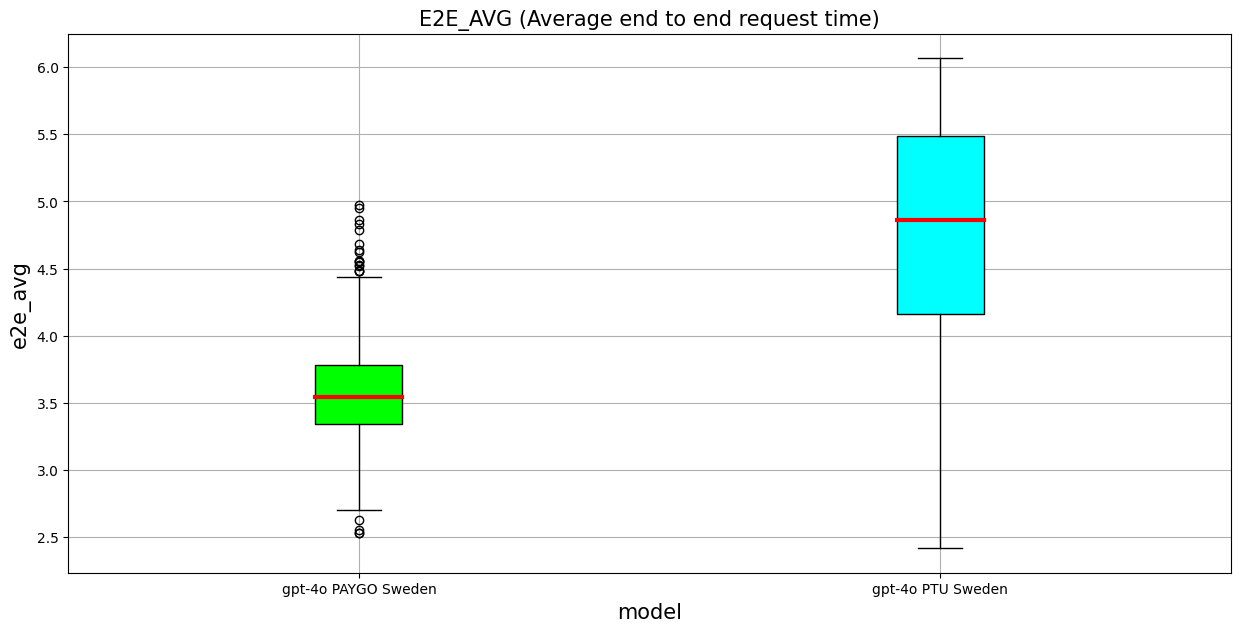

10


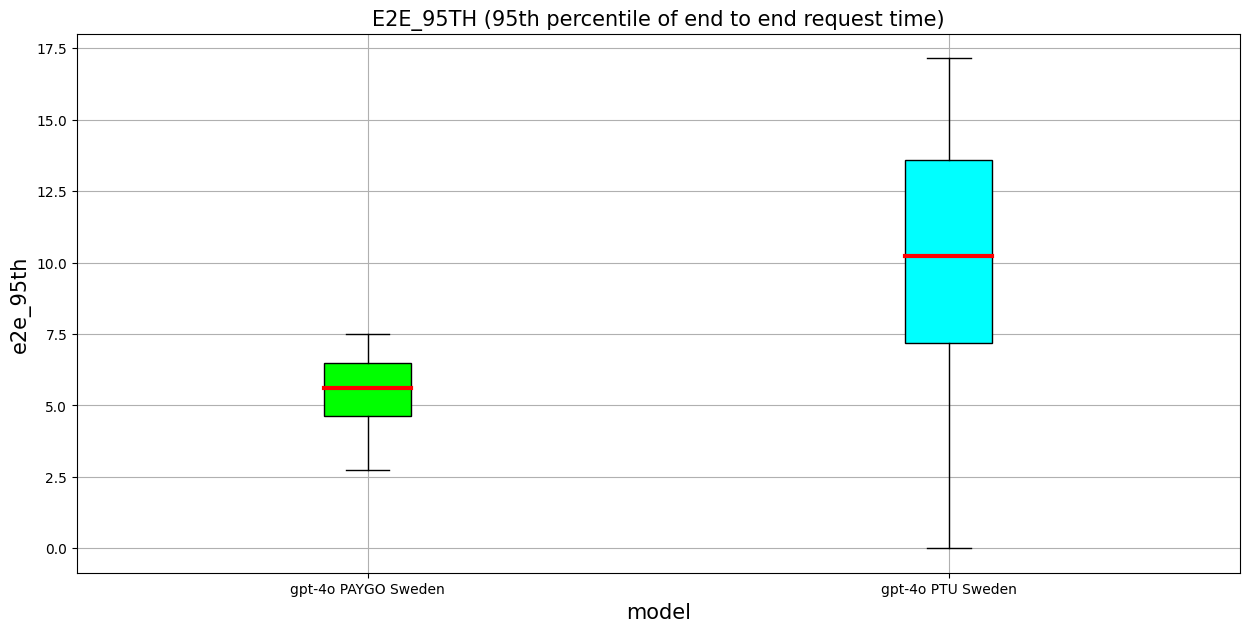

11


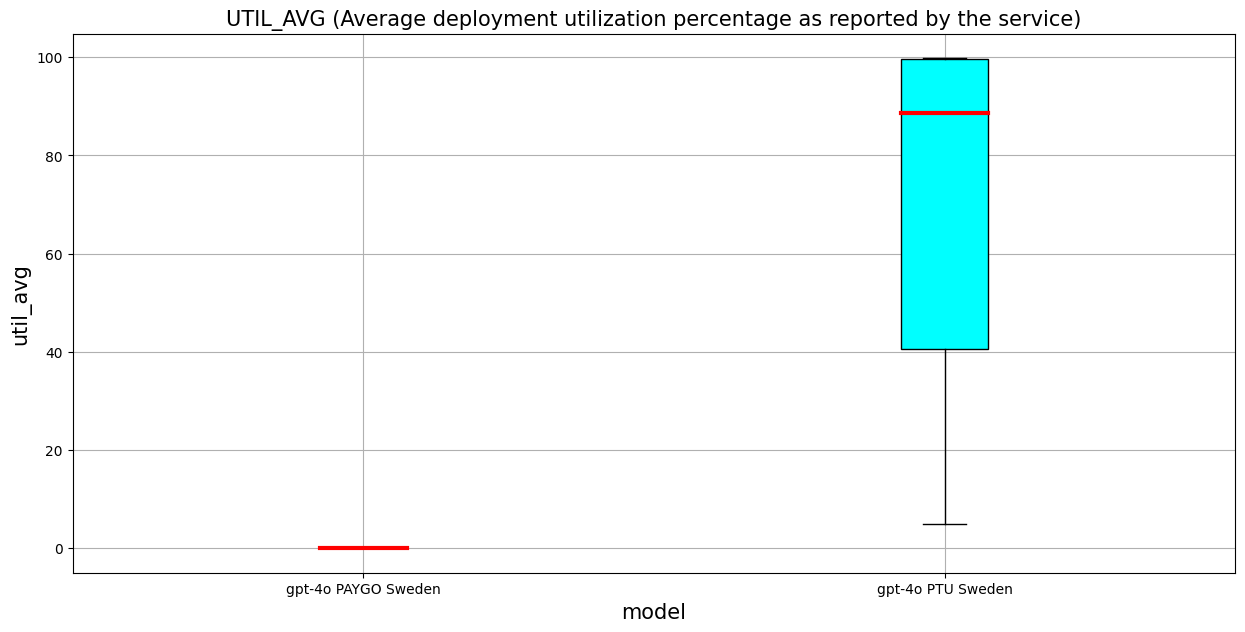

12


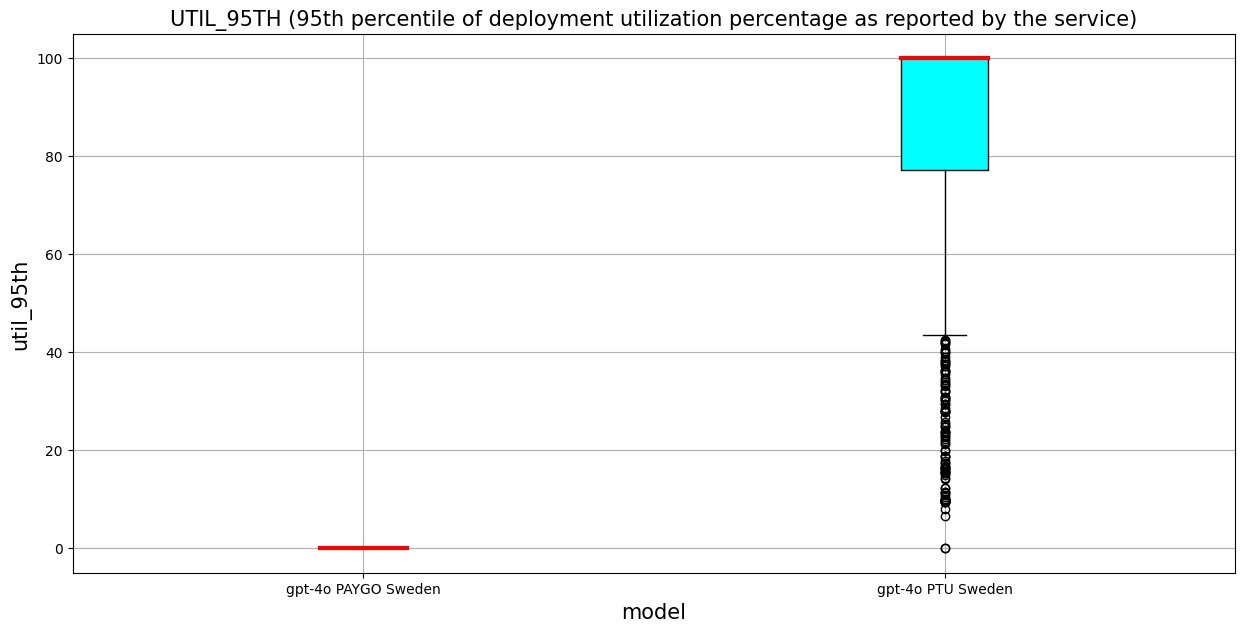

In [29]:
idx = 1
colors = [COLOR1, COLOR2]

for col in cols_to_plot:
    plt.figure(figsize=(15, 7))
    print(idx)
    data_paygo = df[df['model'] == MODEL1][col]
    data_ptu =   df[df['model'] == MODEL2][col]
    bp = plt.boxplot([data_paygo, data_ptu],
                     labels=[MODEL1_LABEL, MODEL2_LABEL],
                     patch_artist=True)
    
    for box, color in zip(bp['boxes'], colors):
        box.set_facecolor(color)
    for median in bp['medians']:
        median.set(color='red', linewidth=3)
    
    plt.title(f'{col.upper()} ({metrics_labels[col]})', fontsize=15)
    plt.xlabel('model', fontsize=15)
    plt.ylabel(col, fontsize=15)
    plt.grid(True)
    plt.savefig(os.path.join(REPORT_DIR, f'boxplot_{col}_{dt}.png'))
    plt.show()
    idx += 1

## 4. Export to Excel

In [30]:
excel_doc = os.path.join(REPORT_DIR, f"benchmarks_{dt}.xlsx")

df.to_excel(excel_doc)

In [31]:
excel_link = FileLink(path=excel_doc)
excel_link

/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow9/code/Users/seretkow/AOAI benchmarks/report4/benchmarks_11Jul2024_153044.xlsx

In [32]:
!ls $excel_doc -l

-rwxrwxrwx 1 root root 118586 Jul 11 13:33 report4/benchmarks_11Jul2024_153044.xlsx


## 5. Export to Word

In [33]:
word_file =  os.path.join(REPORT_DIR, f"benchmarks_{dt}.docx")

add_images_to_word(REPORT_DIR, word_file)

Done. Document saved as report4/benchmarks_11Jul2024_153044.docx


In [34]:
doc_link = FileLink(path=word_file)
doc_link

/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow9/code/Users/seretkow/AOAI benchmarks/report4/benchmarks_11Jul2024_153044.docx

In [35]:
!ls $word_file -l

-rwxrwxrwx 1 root root 2040712 Jul 11 13:33 report4/benchmarks_11Jul2024_153044.docx
